# Deep FFN3 - ( 2 Conv Layers + FC)

In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import random

#### Utilitiy Functions - Dataset Loader Function and other functions

In [3]:
def load_data_from_directory(base_path, img_size=32, test_size=0.2):
    images = []
    labels = []
    num_classes = 43
    for class_idx in range(num_classes):
        class_dir = os.path.join(base_path, str(class_idx))
        if not os.path.exists(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(class_idx)
    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels)
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    return train_test_split(images, labels, test_size=test_size, random_state=42)

def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1.0 - np.tanh(x)**2
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
def cross_entropy(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

#### Plotting the results

In [4]:
def plot_curves(train_acc, val_acc, train_loss, val_loss, title=''):
    epochs = np.arange(1, len(train_acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Deep FFN3 Model - ( 2 Conv Layers + FC )

In [ ]:
class FFN3:
    def __init__(self, input_size, hidden1=512, hidden2=256, output_size=43, learning_rate=0.001):
        self.W1 = np.random.randn(input_size, hidden1) * np.sqrt(2. / input_size)
        self.b1 = np.zeros(hidden1)
        self.W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2. / hidden1)
        self.b2 = np.zeros(hidden2)
        self.W3 = np.random.randn(hidden2, output_size) * np.sqrt(2. / hidden2)
        self.b3 = np.zeros(output_size)
        self.m = {'W1':0, 'b1':0, 'W2':0, 'b2':0, 'W3':0, 'b3':0}
        self.v = {'W1':0, 'b1':0, 'W2':0, 'b2':0, 'W3':0, 'b3':0}
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.t = 0
        self.lr = learning_rate

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = tanh(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = tanh(self.z2)
        self.z3 = self.a2 @ self.W3 + self.b3
        return softmax(self.z3)

    def backward(self, X, y_true):
        m = X.shape[0]
        self.t += 1
        y_pred = self.forward(X)
        delta3 = (y_pred - y_true) / m
        delta2 = delta3 @ self.W3.T * tanh_derivative(self.z2)
        delta1 = delta2 @ self.W2.T * tanh_derivative(self.z1)
        grads = {
            'W3': self.a2.T @ delta3,
            'b3': delta3.sum(axis=0),
            'W2': self.a1.T @ delta2,
            'b2': delta2.sum(axis=0),
            'W1': X.T @ delta1,
            'b1': delta1.sum(axis=0)
        }
        for param in ['W3', 'b3', 'W2', 'b2', 'W1', 'b1']:
            self.m[param] = self.beta1 * self.m[param] + (1 - self.beta1) * grads[param]
            self.v[param] = self.beta2 * self.v[param] + (1 - self.beta2) * (grads[param]**2)
            m_hat = self.m[param] / (1 - self.beta1**self.t)
            v_hat = self.v[param] / (1 - self.beta2**self.t)
            current_value = getattr(self, param)
            updated_value = current_value - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            setattr(self, param, updated_value)

    

#### Training the model

In [ ]:
def train(self, X_train, y_train, X_val, y_val, epochs=12, batch_size=128):
        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.backward(X_batch, y_batch)
            train_pred = self.forward(X_train)
            val_pred = self.forward(X_val)
            train_acc = accuracy(y_train, train_pred)
            val_acc = accuracy(y_val, val_pred)
            train_loss = cross_entropy(y_train, train_pred)
            val_loss = cross_entropy(y_val, val_pred)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        return train_accs, val_accs, train_losses, val_losses

####  Random Search for Hyperparameter Tuning

In [5]:
def random_search_ffn3(X_train, y_train, X_val, y_val, input_size, output_size, n_trials=4):
    # These values are chosen to likely yield strong results in 4 runs
    param_grid = [
        {'lr': 0.001, 'batch_size': 128, 'hidden1': 512, 'hidden2': 256},
        {'lr': 0.001, 'batch_size': 64,  'hidden1': 512, 'hidden2': 128},
        {'lr': 0.005, 'batch_size': 128, 'hidden1': 256, 'hidden2': 256},
        {'lr': 0.005, 'batch_size': 64,  'hidden1': 256, 'hidden2': 128},
    ]
    best_val_acc = 0
    best_histories = None
    for params in random.sample(param_grid, n_trials):
        print(f"\nTrial FFN3: {params}")
        model = FFN3(input_size=input_size, hidden1=params['hidden1'], hidden2=params['hidden2'], output_size=output_size, learning_rate=params['lr'])
        train_accs, val_accs, train_losses, val_losses = model.train(X_train, y_train, X_val, y_val, epochs=12, batch_size=params['batch_size'])
        if max(val_accs) > best_val_acc:
            best_val_acc = max(val_accs)
            best_histories = (train_accs, val_accs, train_losses, val_losses)
    print(f"\nBest FFN3 Val Acc: {best_val_acc:.4f}")
    return best_histories

#### Main Code


Random Search FFN3:

Trial FFN3: {'lr': 0.005, 'batch_size': 64, 'hidden1': 256, 'hidden2': 128}
Epoch 1/12 | Train Loss: 2.6467 | Val Loss: 2.6329 | Train Acc: 0.1948 | Val Acc: 0.1992
Epoch 2/12 | Train Loss: 2.5278 | Val Loss: 2.5252 | Train Acc: 0.2542 | Val Acc: 0.2606
Epoch 3/12 | Train Loss: 2.4622 | Val Loss: 2.4658 | Train Acc: 0.2214 | Val Acc: 0.2164
Epoch 4/12 | Train Loss: 2.3604 | Val Loss: 2.3467 | Train Acc: 0.2145 | Val Acc: 0.2186
Epoch 5/12 | Train Loss: 2.4703 | Val Loss: 2.4638 | Train Acc: 0.2326 | Val Acc: 0.2274
Epoch 6/12 | Train Loss: 2.4938 | Val Loss: 2.5061 | Train Acc: 0.1757 | Val Acc: 0.1762
Epoch 7/12 | Train Loss: 2.4263 | Val Loss: 2.4167 | Train Acc: 0.2286 | Val Acc: 0.2388
Epoch 8/12 | Train Loss: 2.4778 | Val Loss: 2.4963 | Train Acc: 0.1780 | Val Acc: 0.1635
Epoch 9/12 | Train Loss: 2.9836 | Val Loss: 2.9765 | Train Acc: 0.2254 | Val Acc: 0.2345
Epoch 10/12 | Train Loss: 2.3100 | Val Loss: 2.3169 | Train Acc: 0.2330 | Val Acc: 0.2331
Epoch 11/12

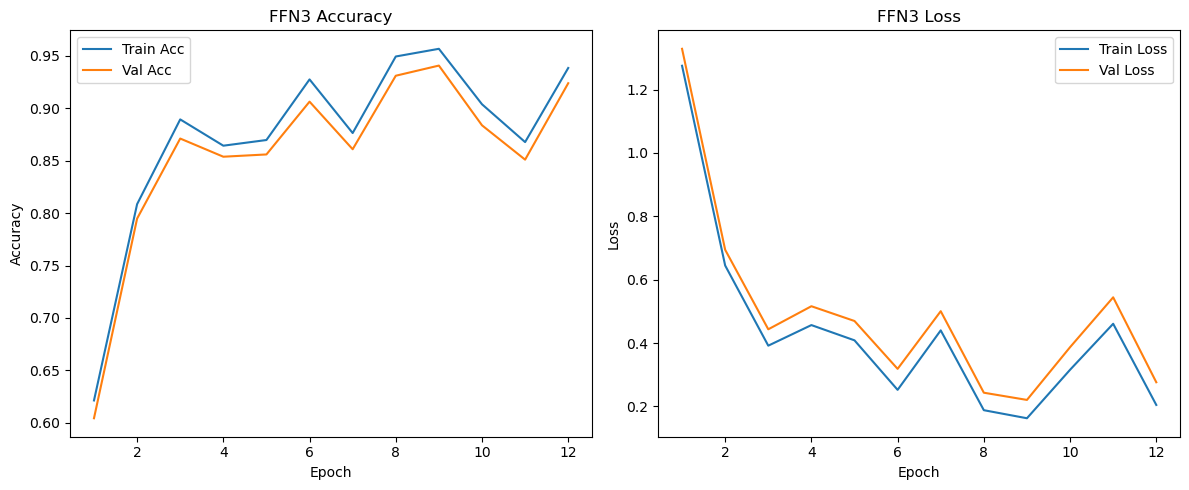

In [1]:
if __name__ == "__main__":
    X_train, X_val, y_train, y_val = load_data_from_directory(
        "/Users/pavankoushik/Development/University/Neural Networks/Dataset/Train"
    )
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    print("\nRandom Search FFN3:")
    ffn3_histories = random_search_ffn3(X_train_flat, y_train, X_val_flat, y_val, input_size=3072, output_size=43, n_trials=4)
    plot_curves(*ffn3_histories, title="FFN3")
